# CUNY IS 622 Final Project

### Introduction

The objective of this project is to build a recommendation system for restaurants using collaborative filtering. The process of identifying similar users and recommending what similar users like is called collaborative filtering. This project is structured in the following manner:
1.	Exploratory data analysis
2.	Neighborhood-based CF recommender
3.	Predict a rating that user gives a restaurant that the user has not encountered before
4.	Error analysis


Import necessary packages and setup parameters

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150

rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'

rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [2]:
fulldf=pd.read_csv("/users/bcarancibia/CUNY_IS_622/FinalProject/bigdf.csv")
fulldf.head(2)

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57


## Exploratory Data Analysis

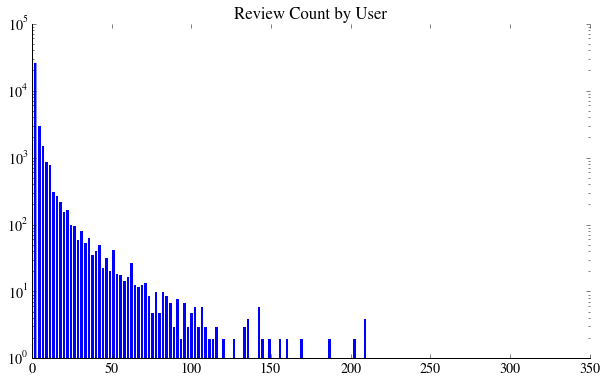

In [3]:
user_review_count=fulldf.groupby('user_id').review_id.count() 

bin_size=len(np.unique(user_review_count.values))    
fig,ax=plt.subplots()

ax.hist(user_review_count,bins=bin_size, log=True)    
ax.set_title('Review Count by User')     
ax.spines['top'].set_visible(False)      
ax.spines['right'].set_visible(False)   

plt.show()

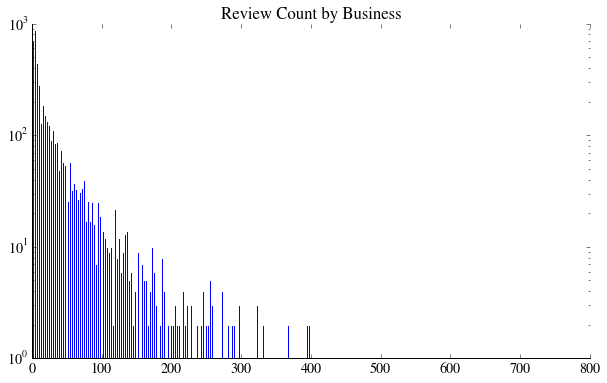

In [4]:

business_review_count=fulldf.groupby('business_id').review_id.count() 

bin_size=len(np.unique(business_review_count.values))    
fig,ax=plt.subplots()

ax.hist(business_review_count,bins=bin_size, log=True)  
ax.set_title('Review Count by Business')
ax.spines['top'].set_visible(False)        
ax.spines['right'].set_visible(False)   

plt.show()

In [5]:
businesses=len(fulldf.business_id.unique())     
users=len(fulldf.user_id.unique())             

print 'Businesses: %d | Users: %d' %(businesses,users)

Businesses: 4503 | Users: 34789


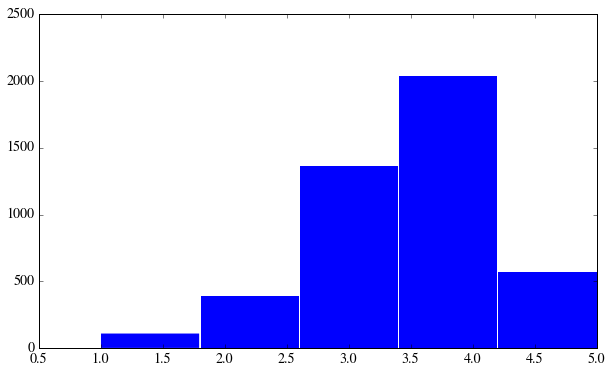

In [6]:
average_rating_rest=fulldf.groupby('business_id').agg({'stars':np.mean})  
plt.hist(average_rating_rest.stars,bins=5)   
plt.show()

In [7]:
def recompute_frame(ldf):
    ldfu=ldf.groupby('user_id')
    ldfb=ldf.groupby('business_id')
    user_avg=ldfu.stars.mean()
    user_review_count=ldfu.review_id.count()
    business_avg=ldfb.stars.mean()
    business_review_count=ldfb.review_id.count()
    nldf=ldf.copy()
    nldf.set_index(['business_id'], inplace=True)
    nldf['business_avg']=business_avg
    nldf['business_review_count']=business_review_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user_id'], inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_review_count']=user_review_count
    nldf.reset_index(inplace=True)
    return nldf

In [8]:
import re

#computing a subset from large dataframe where number of business reviews are more than 150 and user reviews more than 60
smalldf=fulldf[(fulldf.business_review_count>150) & (fulldf.user_review_count>60)]  
smalldf=recompute_frame(smalldf)   #usign the recompute function provided above to re-evaluate the average in smalldf
smalldf_unique_users=np.unique(smalldf.user_id).size   #getting number of unique users in new df 
smalldf_items=smalldf.shape[0]     #getting nuber of entries (rows) in new df

print 'Items: %d' %smalldf_items
print 'Unique Users: %d' %smalldf_unique_users

Items: 6165
Unique Users: 240


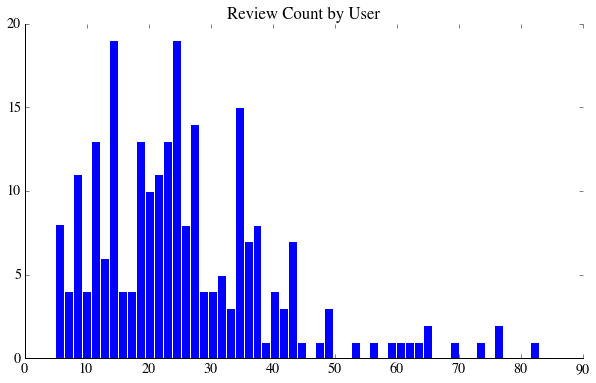

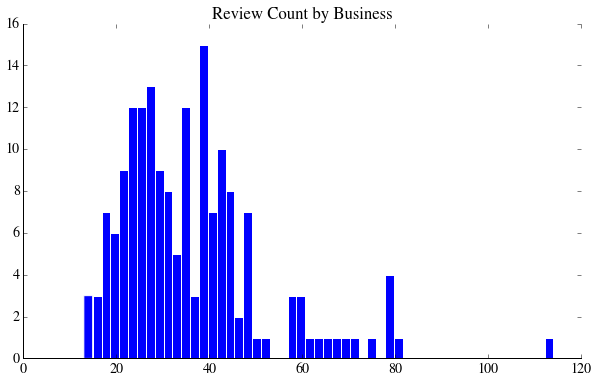

In [9]:
def plot_review_count(column,title):
    business_review_count=smalldf.groupby(column).review_id.count()   
    bin_size=len(np.unique(business_review_count.values))  
    fig,ax=plt.subplots()
    
    ax.hist(business_review_count,bins=bin_size)  
    ax.set_title(title)  
    ax.spines['top'].set_visible(False)  
    ax.spines['right'].set_visible(False)
    
    plt.show()
    
plot_review_count('user_id','Review Count by User')  

plot_review_count('business_id','Review Count by Business') 

Overall Mean: 3.87


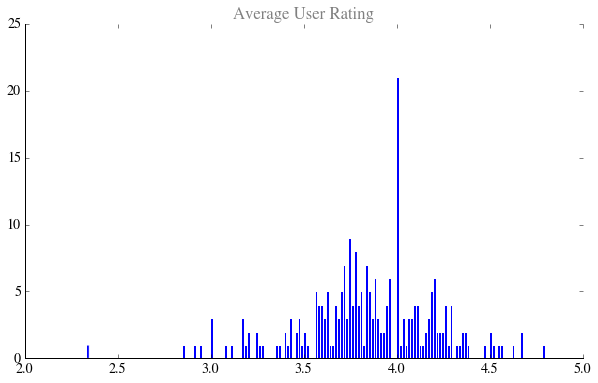

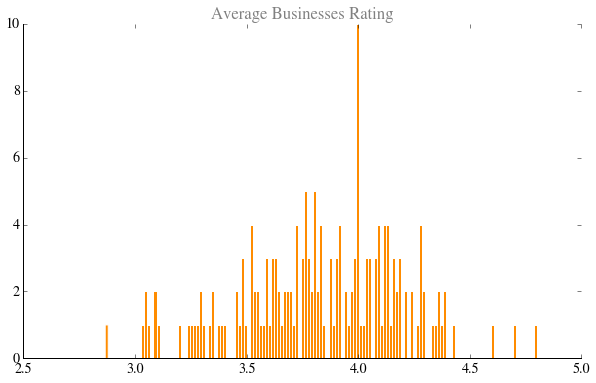

In [10]:
overall_mean=smalldf.stars.mean()
print 'Overall Mean:',round(overall_mean,2)

fig,ax=plt.subplots()
smalldf_users=smalldf[['user_id','user_avg']].drop_duplicates().user_avg

user_bin_size=np.unique(smalldf_users).size
plt.hist(smalldf_users,bins=user_bin_size)
ax.set_title('Average User Rating',color='gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

fig,ax=plt.subplots()
smalldf_businesses=smalldf[['business_id','business_avg']].drop_duplicates().business_avg

business_bin_size=np.unique(smalldf_businesses).size
plt.hist(smalldf_businesses,bins=business_bin_size,color='darkorange')
ax.set_title('Average Businesses Rating',color='gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [11]:
from scipy.stats.stats import pearsonr
def pearson_sim(rest1_reviews, rest2_reviews, n_common):
    if n_common==0:
        rho=0.
    else:
        diff1=rest1_reviews['stars']-rest1_reviews['user_avg']
        diff2=rest2_reviews['stars']-rest2_reviews['user_avg']
        rho=pearsonr(diff1, diff2)[0]
    return rho

Mean support is: 6.84679722562


(array([  7.02000000e+03,   4.98700000e+03,   1.79400000e+03,
          5.90000000e+02,   1.95000000e+02,   7.60000000e+01,
          2.20000000e+01,   1.00000000e+01,   1.00000000e+01,
          2.00000000e+00]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ]),
 <a list of 10 Patch objects>)

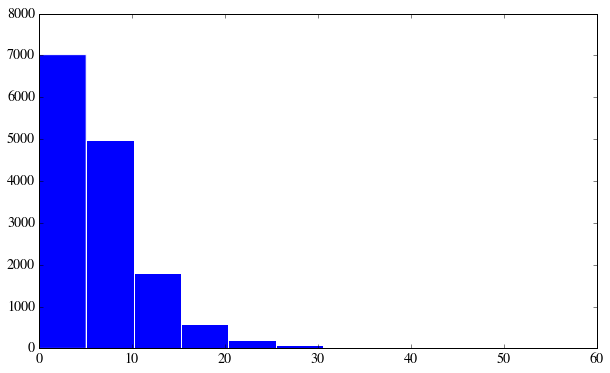

In [12]:
restaurants=smalldf.business_id.unique()
supports=[]
for i,rest1 in enumerate(restaurants):
    for j,rest2 in enumerate(restaurants):
        if  i < j:
            rest1_reviewers = smalldf[smalldf.business_id==rest1].user_id.unique()
            rest2_reviewers = smalldf[smalldf.business_id==rest2].user_id.unique()
            common_reviewers = set(rest1_reviewers).intersection(rest2_reviewers)
            supports.append(len(common_reviewers))
print "Mean support is:",np.mean(supports)
plt.hist(supports)

### Calculate Similarity

In [13]:
def get_restaurant_reviews(restaurant_id, df, set_of_users):
    """
    given a resturant id and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.user_id.isin(set_of_users)) & (df.business_id==restaurant_id)
    reviews = df[mask]
    reviews = reviews[reviews.user_id.duplicated()==False]
    return reviews

In [14]:
def calculate_similarity(rest1,rest2,df,similarity_func): 
    
    reviewers_rest1=df[df.business_id==rest1].user_id   
    reviewers_rest2=df[df.business_id==rest2].user_id 
    reviewers_common=set(reviewers_rest1).intersection(reviewers_rest2) 
    n_common=len(reviewers_common)  
    reviews_rest1=get_restaurant_reviews(rest1, df, reviewers_common) 
    reviews_rest2=get_restaurant_reviews(rest2, df, reviewers_common) 
    similarity=similarity_func(reviews_rest1,reviews_rest2,n_common)
    if np.isnan(similarity): 
        similarity=0
        
    return (similarity,n_common)

In [15]:
class Database:
    "A class representing a database of similaries and common supports"
    
    def __init__(self, df):
        "the constructor, takes a reviews dataframe like smalldf as its argument"
        database={}
        self.df=df
        self.uniquebizids={v:k for (k,v) in enumerate(df.business_id.unique())}
        keys=self.uniquebizids.keys()
        l_keys=len(keys)
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)
        
    def populate_by_calculating(self, similarity_func):
        """
        a populator for every pair of businesses in df. takes similarity_func like
        pearson_sim as argument
        """
        items=self.uniquebizids.items()
        for b1, i1 in items:
            for b2, i2 in items:
                if i1 < i2:
                    sim, nsup=calculate_similarity(b1, b2, self.df, similarity_func)
                    self.database_sim[i1][i2]=sim
                    self.database_sim[i2][i1]=sim
                    self.database_sup[i1][i2]=nsup
                    self.database_sup[i2][i1]=nsup
                elif i1==i2:
                    nsup=self.df[self.df.business_id==b1].user_id.count()
                    self.database_sim[i1][i1]=1.
                    self.database_sup[i1][i1]=nsup
                    

    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.uniquebizids[b1]][self.uniquebizids[b2]]
        nsup=self.database_sup[self.uniquebizids[b1]][self.uniquebizids[b2]]
        return (sim, nsup)

In [16]:
db=Database(smalldf)
db.populate_by_calculating(pearson_sim)
db.get("z3yFuLVrmH-3RJruPEMYKw", "zruUQvFySeXyEd7_rQixBg")

(0.39904554525734559, 7)

In [17]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim
import operator


def knearest(restaurant_id,set_of_restaurants,dbase,k,reg):  
    set_of_restaurants=set_of_restaurants[set_of_restaurants!=restaurant_id]
    k_list=[]
    for rest_id in set_of_restaurants: 
        n_common=dbase.get(restaurant_id, rest_id)[1]        
        sim=dbase.get(restaurant_id, rest_id)[0]            
        shrunk_sim_score=shrunk_sim(sim, n_common, reg=reg)    
        k_list.append((rest_id,shrunk_sim_score,n_common))         
    k_list.sort(key=operator.itemgetter(1),reverse=True)      
    if k is None:k=7        
    return k_list[:k]

In [18]:
testbizid="eIxSLxzIlfExI6vgAbn2JA"
testbizid2="L-uPZxooP_ziXCtRrWi8Pw"

def biznamefromid(df, theid):
    return df['biz_name'][df['business_id']==theid].values[0]
def usernamefromid(df, theid):
    return df['user_name'][df['user_id']==theid].values[0]
print testbizid, biznamefromid(smalldf,testbizid)
print testbizid2, biznamefromid(smalldf, testbizid2)

eIxSLxzIlfExI6vgAbn2JA Lobbys Beef Burgers Dogs
L-uPZxooP_ziXCtRrWi8Pw Café Monarch


## Calculate Nearest Neighbors Similarities Recommendation

In [19]:
tops=knearest(testbizid, smalldf.business_id.unique(), db, k=7, reg=3.)
print "For ",biznamefromid(smalldf, testbizid), ", top matches are:"
for i, (biz_id, sim, nc) in enumerate(tops):
    print i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc

For  Lobbys Beef Burgers Dogs , top matches are:
0 La Condesa Gourmet Taco Shop | Sim 0.598714448434 | Support 6
1 Citizen Public House | Sim 0.571428571429 | Support 4
2 FnB | Sim 0.527129890943 | Support 5
3 Defalco's Italian Grocery | Sim 0.519456555658 | Support 6
4 Republic Ramen + Noodles | Sim 0.519140146937 | Support 5
5 unPhogettable | Sim 0.5 | Support 3
6 Haus Murphy's | Sim 0.467637235308 | Support 3


In [20]:
tops2=knearest(testbizid2, smalldf.business_id.unique(), db, k=7, reg=3.)
print "For ",biznamefromid(smalldf, testbizid2), ", top matches are:"
for i, (biz_id, sim, nc) in enumerate(tops2):
    print i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc

For  Café Monarch , top matches are:
0 Postino Arcadia | Sim 0.625 | Support 5
1 The Main Ingredient Ale House And Café | Sim 0.571428571429 | Support 4
2 Brio Tuscan Grille | Sim 0.571428571429 | Support 4
3 Kazimierz World Wine Bar | Sim 0.5 | Support 3
4 Harlow's Cafe | Sim 0.5 | Support 3
5 The Fry Bread House | Sim 0.5 | Support 3
6 Cien Agaves Tacos & Tequila | Sim 0.5 | Support 3


## Calculate User Top Choices

In [21]:
def get_user_top_choices(user_id, df, numchoices=5):
    "get the sorted top 5 restaurants for a user by the star rating the user gave them"
    udf=df[df.user_id==user_id][['business_id','stars']].sort(['stars'], ascending=False).head(numchoices)
    return udf
testuserid="7cR92zkDv4W3kqzii6axvg"
print "For user", usernamefromid(smalldf,testuserid), "top choices are:" 
bizs=get_user_top_choices(testuserid, smalldf)['business_id'].values
[biznamefromid(smalldf, biz_id) for biz_id in bizs]

For user Vern top choices are:


['Tee Pee Mexican Food',
 'Local Breeze',
 "Carly's Bistro",
 'District American Kitchen and Wine Bar',
 'Sonora Mesquite Grill']

In [22]:
def get_top_recos_for_user(userid,df,dbase,n,k,reg):
    
    if k is None: k=8   
    
   
    top_choices=get_user_top_choices(userid, df, numchoices=n).business_id.values  
    

    nearest_list=[]
    for top_choice_restid in top_choices:      
       
        nearest_list.append(knearest(top_choice_restid,df.business_id.unique(),dbase,k,reg))  
    
    b_id=[tuples[0] for tuples in sum(nearest_list,[])]  
    b_id=list(set(b_id)) 
    subdf=df[df['business_id'].isin(b_id)]
    user_rated=list(subdf[subdf.user_id==testuserid].business_id.values) 
    subdf = subdf[-subdf['business_id'].isin(user_rated)]    
    
    df_mean=subdf[['business_id','business_avg']].groupby('business_id')['business_avg'].mean()
    
    top_recomen=[(rest,avg) for rest,avg in zip(df_mean.index, df_mean.values)]
    top_recomen.sort(key=operator.itemgetter(1),reverse=True)   
    
    
    return top_recomen

In [23]:
print "For user", usernamefromid(smalldf,testuserid), "the top recommendations are:"
toprecos=get_top_recos_for_user(testuserid, smalldf, db, n=5, k=7, reg=3.)
for biz_id, biz_avg in toprecos:
    print biznamefromid(smalldf,biz_id), "| Average Rating |", biz_avg

For user Vern the top recommendations are:
Rokerij | Average Rating | 4.37931034483
Wildfish Seafood Grille | Average Rating | 4.29411764706
Defalco's Italian Grocery | Average Rating | 4.23255813953
Cornish Pasty Company | Average Rating | 4.20689655172
Pappadeaux Seafood Kitchen | Average Rating | 4.18518518519
Four Peaks Brewing Co | Average Rating | 4.16666666667
Yasu Sushi Bistro | Average Rating | 4.07692307692
Pho Thanh | Average Rating | 4.04761904762
Carolina's Mexican Food | Average Rating | 3.91176470588
Pita Jungle | Average Rating | 3.91176470588
The Main Ingredient Ale House And Café | Average Rating | 3.89743589744
Malee's Thai Bistro | Average Rating | 3.875
Butterfield's Pancake House | Average Rating | 3.83333333333
Joe's Real BBQ | Average Rating | 3.81578947368
Arcadia Farms Cafe | Average Rating | 3.79310344828
Delux | Average Rating | 3.77611940299
CherryBlossom Noodle Cafe | Average Rating | 3.75
SanTan Brewing Company | Average Rating | 3.73076923077
Republic Ra

## Predict User Rating

In [24]:
def knearest_amongst_userrated(restaurant_id,user_id,df,dbase,k,reg):
    '''#took this line from HW's get_user_top_choices function without the head(n) limit
    set_business_id=df[df.user_id==user_id][['business_id','stars']].sort(['stars'], ascending=False).business_id.values
    set_business_id=df[df.user_id==user_id][['business_id','stars']]'''
   
    if k is None: k=7  
    set_business_id=get_user_top_choices(user_id, df, numchoices=500).business_id.values
    
    knearest_rest= knearest(restaurant_id,set_business_id,dbase,k,reg)   
    
    return knearest_rest

def rating(df,dbase,restaurant_id,user_id,k,reg):
    
    if k is None: k=7 
        
    knearest_rest=knearest_amongst_userrated(restaurant_id,user_id,df,dbase,k,reg)
    
    '''y_um_baseline is over complete dataframe''' 
    y=df.stars.mean() 
    y_u=df[df.user_id==user_id].user_avg.unique().mean()  
    y_m=df[df.business_id==restaurant_id].stars.mean()     
    
    y_um_baseline=y+(y_u-y)+(y_m-y)  
    
    
    '''smj_sum is the denominator in the formula, sum of similaritie in knearest restaurants'''
    smj_sum=sum([sim[1] for sim in knearest_rest])
    
    
    '''calculate numerator from knearest restaurant'''
    knearest_bid=[b_id[0] for b_id in knearest_rest]  
    knearest_df=df[df['business_id'].isin(knearest_bid)]  
    
    y_baseline_uj=df.stars.mean() #y bar for uj, same as y bar for um
    yu_baseline_uj=knearest_df[knearest_df['user_id']==user_id].user_avg.unique()[0]   
    
    numerator=0
    
    for tupple in knearest_rest:  
        
        yj_baseline_uj=knearest_df[knearest_df['business_id']==tupple[0]].stars.mean()
        
        yuj = knearest_df[(knearest_df['business_id']==tupple[0])&(knearest_df['user_id']==user_id)].stars.values[0]
        
        yuj_baseline=y_baseline_uj+(yu_baseline_uj-y_baseline_uj)+(yj_baseline_uj-y_baseline_uj)
        
        smj=tupple[1] 
        
        numerator=numerator+(smj*(yuj-yuj_baseline))
    
    if smj_sum==0:
        y_um=y_um_baseline
    else:
        y_um=y_um_baseline+(numerator/smj_sum)   #compute the y_um using the formula provided
    
    return y_um

In [25]:
print "User Average", smalldf[smalldf.user_id==testuserid].stars.mean(),"for",usernamefromid(smalldf,testuserid)
print "Predicted ratings for top choices calculated earlier:"
for biz_id,biz_avg in toprecos:
    print biznamefromid(smalldf, biz_id),"|",rating(smalldf, db, biz_id, testuserid, k=7, reg=3.),"|","Average",biz_avg 

User Average 3.5652173913 for Vern
Predicted ratings for top choices calculated earlier:
Rokerij | 4.71714023074 | Average 4.37931034483
Wildfish Seafood Grille | 4.27594504172 | Average 4.29411764706
Defalco's Italian Grocery | 3.822223075 | Average 4.23255813953
Cornish Pasty Company | 4.62810510121 | Average 4.20689655172
Pappadeaux Seafood Kitchen | 4.08845573953 | Average 4.18518518519
Four Peaks Brewing Co | 4.26174734161 | Average 4.16666666667
Yasu Sushi Bistro | 4.61103444018 | Average 4.07692307692
Pho Thanh | 4.10317798035 | Average 4.04761904762
Carolina's Mexican Food | 4.31700962152 | Average 3.91176470588
Pita Jungle | 4.40378787384 | Average 3.91176470588
The Main Ingredient Ale House And Café | 3.88743659505 | Average 3.89743589744
Malee's Thai Bistro | 4.39994642565 | Average 3.875
Butterfield's Pancake House | 3.77611292043 | Average 3.83333333333
Joe's Real BBQ | 3.97629233918 | Average 3.81578947368
Arcadia Farms Cafe | 3.14091506468 | Average 3.79310344828
Delux |

In [26]:
def get_other_ratings(restaurant_id, user_id, df):
    "get a user's rating for a restaurant and the restaurant's average rating"
    choice=df[(df.business_id==restaurant_id) & (df.user_id==user_id)]
    users_score=choice.stars.values[0]
    average_score=choice.business_avg.values[0]
    return users_score, average_score

In [27]:

print "for user",usernamefromid(smalldf,testuserid), 'avg', smalldf[smalldf.user_id==testuserid].stars.mean() 
for biz_id in bizs:
    print "----------------------------------"
    print biznamefromid(smalldf, biz_id)
    print "Predicted Rating:",rating(smalldf, db, biz_id, testuserid, k=7, reg=3.) 
    u,a=get_other_ratings(biz_id, testuserid, smalldf)
    print "Actual User Rating:",u,"Avg Rating",a

for user Vern avg 3.5652173913
----------------------------------
Tee Pee Mexican Food
Predicted Rating: 3.52640184162
Actual User Rating: 5 Avg Rating 3.04347826087
----------------------------------
Local Breeze
Predicted Rating: 4.2280987611
Actual User Rating: 5 Avg Rating 4.0
----------------------------------
Carly's Bistro
Predicted Rating: 3.99008654065
Actual User Rating: 5 Avg Rating 3.5
----------------------------------
District American Kitchen and Wine Bar
Predicted Rating: 3.80281696528
Actual User Rating: 4 Avg Rating 3.55263157895
----------------------------------
Sonora Mesquite Grill
Predicted Rating: 4.08382083034
Actual User Rating: 4 Avg Rating 4.38461538462


## Error Analysis

In [28]:
def compare_results(stars_actual, stars_predicted, ylow=-10, yhigh=15, title=""):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    fig=plt.figure()
    
    
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    ax=plt.scatter(df.actual, df.predicted, alpha=0.2, s=30, label="predicted")
    plt.ylim([ylow,yhigh])
    plt.plot([1,5],[1,5], label="slope 1")
    xp=[1,2,3,4,5]
    yp=df.groupby('actual').predicted.mean().values
    plt.plot(xp,yp,'k', label="means")
    sig=df.groupby('actual').predicted.std().values
    plt.fill_between(xp, yp - sig, yp + sig, 
                 color='k', alpha=0.2)
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.legend(frameon=False)
    remove_border()
    plt.grid(False)
    plt.title(title)
    print np.mean(np.abs(df.predicted) < 15)

0.999837793998
0.999675587997
0.993349553933
0.994484995945


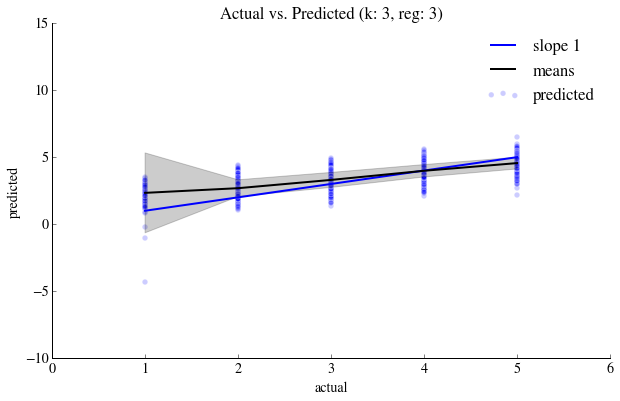

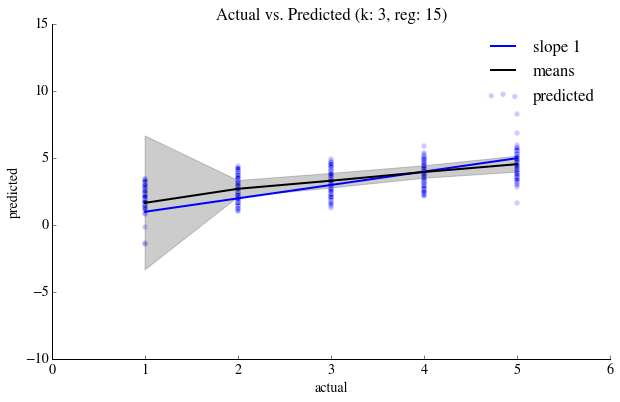

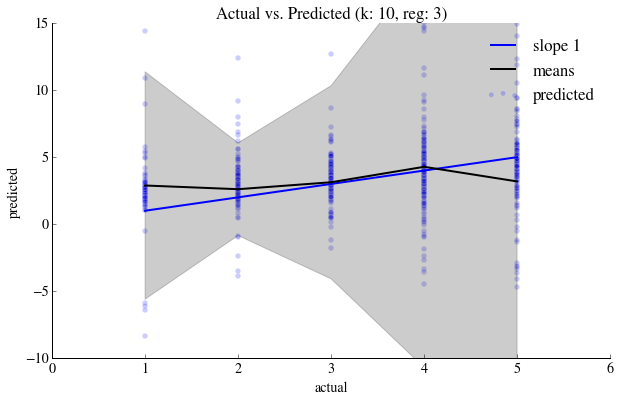

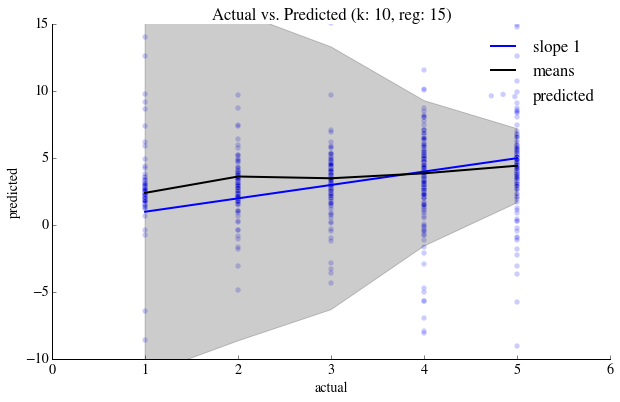

In [29]:
k=[3,3,10,10]   
reg=[3,15,3,15]  

for k_i,reg_i in zip(k,reg):
    
    stars_predicted=np.array([])   
    stars_actual=np.array([])
    
    for stars,restid,userid in zip(smalldf.stars,smalldf.business_id,smalldf.user_id):
        
        stars_predicted=np.append(stars_predicted,rating(smalldf,db,restid,userid,k=k_i,reg=reg_i))
        
        stars_actual=np.append(stars_actual,stars)
    
    compare_results(stars_actual, stars_predicted, ylow=-10, yhigh=15, title="Actual vs. Predicted (k: %d, reg: %d)"%(k_i,reg_i))